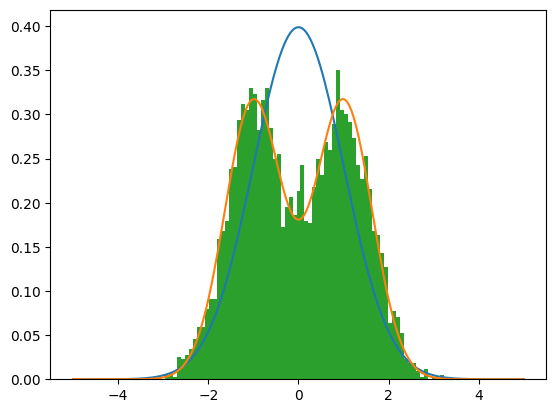

In [12]:
from misc import * 
P = torch.distributions.MultivariateNormal(torch.zeros(1), torch.eye(1))
Q = torch.distributions.MixtureSameFamily(torch.distributions.Categorical(torch.tensor([.5,.5])), torch.distributions.MultivariateNormal(torch.tensor([[-1.],[1.]]), torch.tensor([[[.40]],[[.40]]])))
tt = torch.linspace(-5,5,200)
plt.plot(tt, torch.exp(P.log_prob(tt.unsqueeze(-1))))
plt.plot(tt, torch.exp(Q.log_prob(tt.unsqueeze(-1))))
Q_samples = Q.sample([5000])
P_samples = P.sample([500])
plt.hist(Q_samples.numpy(), density = True, bins = 75)
plt.show()

In [13]:
def unadjusted_step(x,p_log_prob,tau):
    u = torch.sum(p_log_prob(x))
    grad = torch.autograd.grad(u,x)[0]
    return x + tau * grad + (2 * tau) ** (1 / 2) * torch.randn(x.shape)

In [18]:
import torch
from tqdm import tqdm

class BinaryClassifierPrime(torch.nn.Module):
    def __init__(self, label_0_samples,label_1_samples,label_1_log_prob,hidden_dims = []):
        super().__init__()
        self.label_0_samples = label_0_samples
        self.label_1_samples = label_1_samples
        self.p = label_0_samples.shape[-1]
        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.SiLU(), ])
        network.pop()
        self.f = torch.nn.Sequential(*network)
        self.label_1_log_prob = label_1_log_prob
        self.r = lambda x: torch.exp(self.label_1_log_prob(x))/(torch.exp(self.label_1_log_prob(x)) + torch.exp(self.f(x).squeeze((-1))))
        self.logit_r = lambda x: torch.logit(self.r(x))
        self.w = torch.distributions.Dirichlet(torch.ones(self.label_0_samples.shape[0] + self.label_1_samples.shape[0])).sample()

    def loss(self, samples, labels, w):
        label_0_samples = samples[labels == 0]
        label_0_w = w[labels == 0]
        label_1_samples = samples[labels == 1]
        label_1_w = w[labels == 1]
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.sum(label_1_w * log_sigmoid(self.logit_r(label_1_samples))) - torch.sum(label_0_w * log_sigmoid(-self.logit_r(label_0_samples)))
        
    def train(self, epochs, batch_size=None, lr=5e-3, weight_decay=5e-6, verbose = False, number_langevin_steps = 1):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        if batch_size is None:
            batch_size = self.label_0_samples.shape[0] + self.label_0_samples.shape[0]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        device = torch.device('cpu')
        self.to(device)

        if verbose:
            pbar = tqdm(range(epochs))
        else:
            pbar = range(epochs)
        for t in pbar:
            samples = torch.cat([self.label_0_samples, self.label_1_samples], dim = 0).to(device)
            labels= torch.cat([torch.zeros(self.label_0_samples.shape[0]), torch.ones(self.label_1_samples.shape[0])], dim = 0).long().to(device)
            dataset = torch.utils.data.TensorDataset(samples, labels, self.w.to(device))
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for batch in dataloader:
                optimizer.zero_grad()
                batch_loss = self.loss(batch[0], batch[1], batch[2])
                batch_loss.backward()
                optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0], batch[1],batch[2]) for batch in dataloader]).mean().item()
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss, 6)) + '; device = ' + str(device))
        self.to(torch.device('cpu'))
    

In [19]:
classif = BinaryClassifierPrime(Q_samples,P_samples,P.log_prob,[32,32,32])
classif.train(200, verbose = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.57it/s, loss = 0.296408; device = cpu]


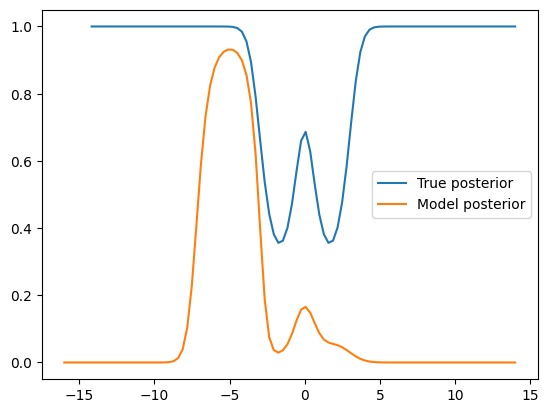

In [20]:
import matplotlib.pyplot as plt
tt = torch.linspace(-16,14,100)
posterior = lambda x: torch.exp(P.log_prob(x))/(torch.exp(P.log_prob(x))+ torch.exp(Q.log_prob(x)))
plt.plot(tt, posterior(tt.unsqueeze(-1)), label = 'True posterior')
with torch.no_grad():
    plt.plot(tt,torch.sigmoid(classif.logit_r(tt.unsqueeze(-1))) , label = 'Model posterior')
plt.legend()

In [17]:
classif = ClassifierFromDensity(Q_samples, P.log_prob, [32,32])
classif.train(200, verbose = True)

NameError: name 'ClassifierFromDensity' is not defined

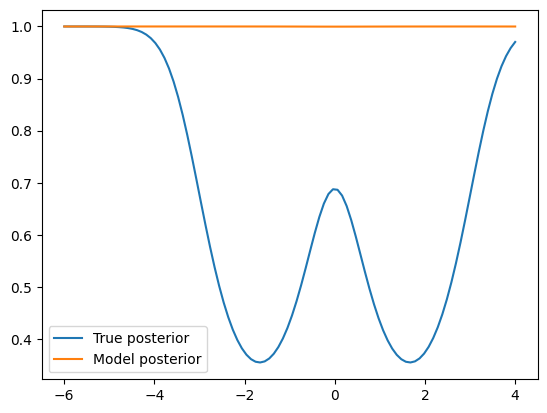

In [36]:
import matplotlib.pyplot as plt
tt = torch.linspace(-6,4,100)
posterior = lambda x: torch.exp(P.log_prob(x))/(torch.exp(P.log_prob(x))+ torch.exp(Q.log_prob(x)))
plt.plot(tt, posterior(tt.unsqueeze(-1)), label = 'True posterior')
with torch.no_grad():
    plt.plot(tt,torch.exp(classif.log_prob(tt.unsqueeze(-1))[:,1]) , label = 'Model posterior')
plt.legend()

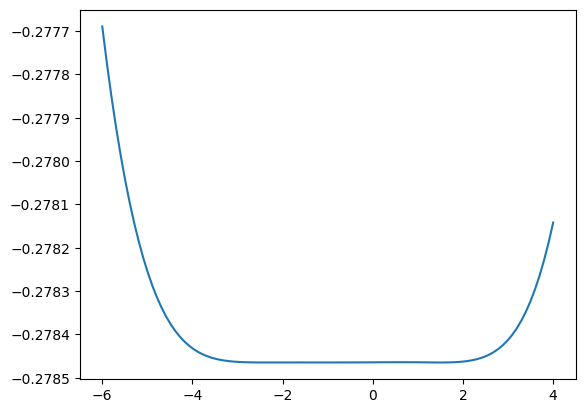

In [6]:
with torch.no_grad():
    ratio = lambda x: torch.exp(P(x) - Q(x))
    plt.plot(tt, classif.f(tt.unsqueeze(-1)))